# Warehouse Optimization (Model Only)

## Initilization

In [130]:
import pandas as pd
import pandas_profiling
import numpy as np
data = pd.read_csv('ML_datafile.csv')
data.reset_index(drop=True, inplace=True)
data = data.drop(['Item No', 'Manufacturer No', 'Product Name', 'Date', 'STOCK TYPE', 'In Stock', 'List No',
                 'UPC Code', 'SaleRate','Blowout'], axis=1)
data

,Manufacturer,Category,Category Path 1,Category Path 2,Category Path 3,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),SaleRateNew
0,Supermicro,Power Cable,Component,Cable,Power Cable,10.25,7.6875,1,2.5,0.0625,1.00,0.000000
1,ASUS,Bag & Sleeve,PC & Laptop,Accessory,Bag & Sleeve,9.23,4.2300,1,2.5,2.5000,0.50,0.000000
2,AMD,Others,Component,CPU / Processor,Desktop CPU,76.88,57.6600,1,2.5,16.7200,0.74,0.000000
3,QNAP,DDR3 1333,Component,DRAM Memory,Notebook DRAM,76.88,57.6600,1,0.0,19.2200,0.10,0.000000
4,Supermicro,Accessory,Hardware & Software,Server & Workstation,Accessory,92.76,69.5700,1,2.5,20.6900,0.50,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4195,NVIDIA,Nvidia,Component,Video Card,PCI Express Video Card,3854.00,2890.5000,1,2.5,961.0000,5.00,0.370787
4196,Supermicro,Accessory,Hardware & Software,Server & Workstation,Accessory,20.50,15.3750,1,2.5,2.6250,0.50,0.377778
4197,In Win,2U,Component,Server,Server Chassis,72.00,54.0000,1,3.5,14.5000,24.12,0.377778
4198,iStarUSA,3U,Component,Server,Server Chassis,143.50,107.6250,1,10.0,25.8750,29.00,0.377778


In [131]:
# limit to categorical data using df.select_dtypes()
#nominal_data = data.drop(['Price(USD)', 'Cost price', 'Inventory', 'Shipping', 'Profit', 'weight(lb)', 'SaleRateNew'], axis=1)
#ordinal_data = data.drop(nominal_data.columns)
nominal_data = data.select_dtypes(include=[object])
ordinal_data = data.drop(list(nominal_data.columns), axis=1)
nominal_data = nominal_data.replace(np.nan, 'Default', regex=True)

## One-Hot Encoding

In [132]:
from sklearn import preprocessing
nominal_data_2 = nominal_data
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(nominal_data_2)
# 3. Transform
onehotlabels = enc.transform(nominal_data_2).toarray()
print(onehotlabels.shape)

(4200, 458)


In [133]:
encoded_data = pd.concat([ordinal_data, pd.DataFrame(onehotlabels)], axis=1)

In [134]:
encoded_data.columns

Index([ 'Price(USD)',  'Cost price',   'Inventory',    'Shipping',
            'Profit',  'weight(lb)', 'SaleRateNew',             0,
                   1,             2,
       ...
                 448,           449,           450,           451,
                 452,           453,           454,           455,
                 456,           457],
      dtype='object', length=465)

In [135]:
encoded_data.head(30)

,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),SaleRateNew,0,1,2,...,448,449,450,451,452,453,454,455,456,457
0,10.25,7.6875,1,2.5,0.0625,1.00,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.23,4.2300,1,2.5,2.5000,0.50,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,76.88,57.6600,1,2.5,16.7200,0.74,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76.88,57.6600,1,0.0,19.2200,0.10,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,92.76,69.5700,1,2.5,20.6900,0.50,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,186.55,139.9125,1,0.0,46.6375,0.08,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,263.94,197.9550,1,10.0,55.9850,28.00,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,262.40,196.8000,1,2.5,63.1000,5.00,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,263.42,197.5650,1,2.5,63.3550,6.50,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,480.72,360.5400,1,2.5,117.6800,0.50,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
#Library Import
import random
import pandas as pd
import numpy as np
import pickle
from math import sqrt
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve

## Data Split

In [138]:
X = encoded_data.drop('SaleRateNew', axis=1)
Y = encoded_data['SaleRateNew']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= 0.5, random_state = 1)
X_train.head(5)

,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),0,1,2,3,...,448,449,450,451,452,453,454,455,456,457
2490,81.99,61.4925,5,2.5,17.9975,3.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3291,146.58,109.9350,16,0.0,36.6450,0.10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1690,40.99,30.7425,150,2.5,7.7475,0.84,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1672,145.00,108.7500,5,0.0,36.2500,0.07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,25.62,19.2150,24,2.5,3.9050,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Training with validation 

In [152]:
from matplotlib import pyplot as plt
%matplotlib inline

def train(models, X, Y, iterations = 5):
    results = {}
    for i in models:
        print("\nRunning ", i)
        r2_train = []
        r2_val = []
        mae_train = []
        mae_val = []
        mse_train = []
        mse_val = []
        mabe_train = []
        mabe_val = []
        mevs_train = []
        mevs_val = []
        for j in range(1, iterations):
            print(j, end='')
            h = int(4200/iterations*j)
            r2_train.append(metrics.r2_score(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            r2_val.append(metrics.r2_score(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mae_train.append(metrics.mean_absolute_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mae_val.append(metrics.mean_absolute_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mse_train.append(metrics.mean_squared_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mse_val.append(metrics.mean_squared_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mabe_train.append(metrics.median_absolute_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mabe_val.append(metrics.median_absolute_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mevs_train.append(metrics.explained_variance_score(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mevs_val.append(metrics.explained_variance_score(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                    y_train.head(h)).predict(X_train)))
            
#R2 score
        fig, ax = plt.subplots()       
        plt.xlabel('Iterations') 
        plt.ylabel('Score') 
        ax.plot(r2_train, label='train')
        ax.plot(r2_val, label='test')
        plt.title("r2_val-train_score " + i)
        ax.legend()
        plt.figure()
#mae
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mae_train, label='train')
        ax.plot(mae_val, label='test')
        plt.title("mean_absolute_error_train-val " + i)
        ax.legend()
        plt.figure()
#mse
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mse_train, label='train')
        ax.plot(mse_val, label='val')
        plt.title("mean_squared_error_train-val " + i)
        ax.legend()
        plt.figure()
#mabe        
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mabe_train, label='train')
        ax.plot(mabe_val, label='val')
        plt.title("median_absolute_error_train-val " + i)
        ax.legend()
        plt.figure()
#mevs
        fig, ax = plt.subplots()
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mevs_train, label='train')
        ax.plot(mevs_val, label='val')
        plt.title("explained_variance_score_train-val " + i)
        ax.legend()
        plt.figure()
        
        results[i] = [r2_train[-1], r2_val[-1],mae_train[-1],mae_val[-1],mse_train[-1],mse_val[-1],mabe_train[-1],mabe_val[-1],
                      mevs_train[-1],mevs_val[-1]]
                      
    return pd.DataFrame(results), models

In [153]:
# np.mean(r2_test), np.mean(mae_train), np.mean(mae_test), 
                     # np.mean(mse_train), np.mean(mse_test), np.mean(mevs_train), np.mean(mevs_test), 
                     # np.mean(mabe_train), np.mean(mabe_test)

In [175]:
models = {'OLS' : linear_model.LinearRegression(),
         'Lasso' : linear_model.Lasso(),
         'Ridge' : linear_model.Ridge(),
         'Ada' : AdaBoostRegressor(),
         'GBM': GradientBoostingRegressor(),
         'RFR' :RandomForestRegressor()}


Running  OLS
1234
Running  Lasso
1234
Running  Ridge
1234
Running  Ada
1234
Running  GBM
1234
Running  RFR
1234Wall time: 2min 36s


,OLS,Lasso,Ridge,Ada,GBM,RFR
0,0.641097,0.632811,0.651056,0.829416,0.827540,0.807824
1,0.727477,0.669600,0.725177,0.853169,0.911018,0.971974
2,0.472777,0.503995,0.466517,0.249667,0.248803,0.254755
3,0.426090,0.486787,0.429148,0.253939,0.210763,0.097203
4,0.496689,0.508157,0.482907,0.208968,0.240838,0.252327
5,0.365496,0.443118,0.368581,0.194092,0.119339,0.036232
6,0.338968,0.409176,0.338545,0.103722,0.104670,0.096128
7,0.324238,0.409015,0.324720,0.108545,0.098270,0.038693
8,0.642676,0.636114,0.652662,0.846155,0.826862,0.817634
9,0.727477,0.669600,0.725177,0.869732,0.911018,0.973443


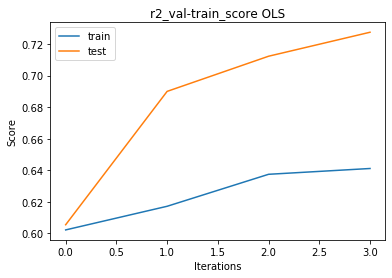

<Figure size 432x288 with 0 Axes>

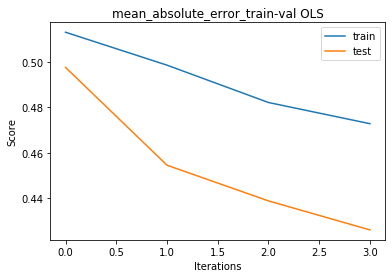

<Figure size 432x288 with 0 Axes>

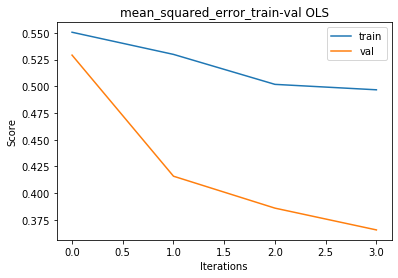

<Figure size 432x288 with 0 Axes>

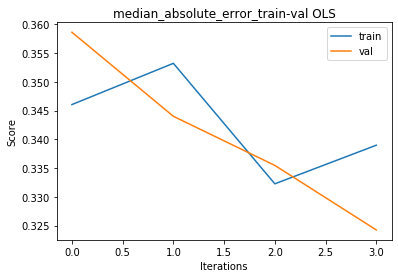

<Figure size 432x288 with 0 Axes>

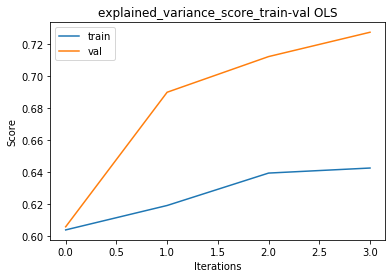

<Figure size 432x288 with 0 Axes>

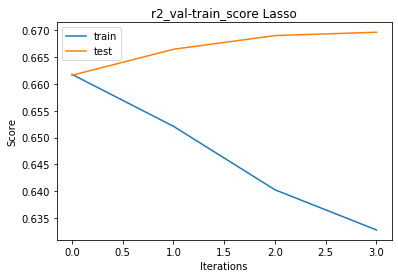

<Figure size 432x288 with 0 Axes>

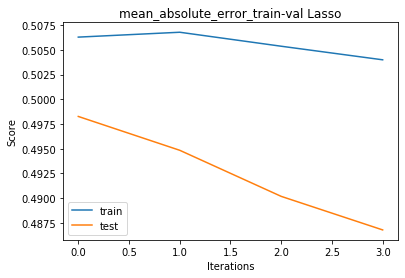

<Figure size 432x288 with 0 Axes>

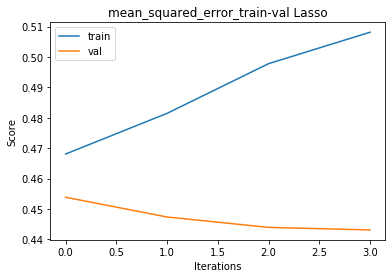

<Figure size 432x288 with 0 Axes>

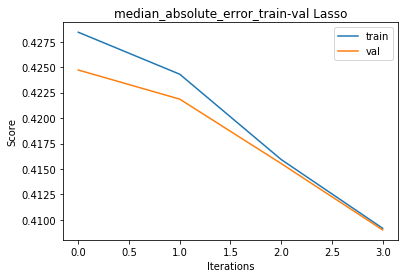

<Figure size 432x288 with 0 Axes>

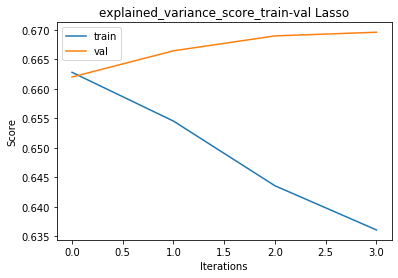

<Figure size 432x288 with 0 Axes>

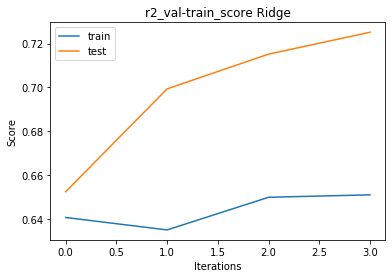

<Figure size 432x288 with 0 Axes>

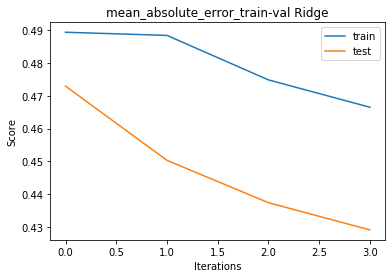

<Figure size 432x288 with 0 Axes>

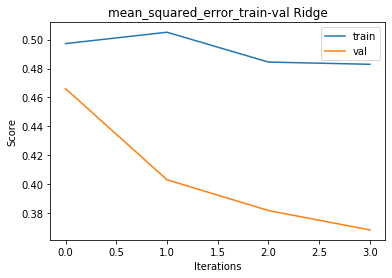

<Figure size 432x288 with 0 Axes>

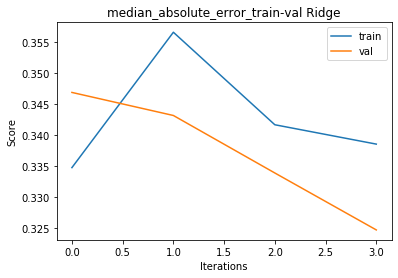

<Figure size 432x288 with 0 Axes>

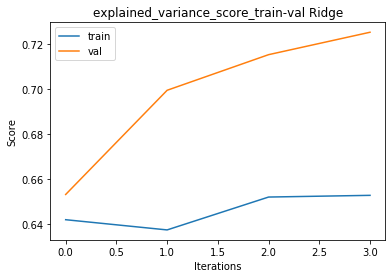

<Figure size 432x288 with 0 Axes>

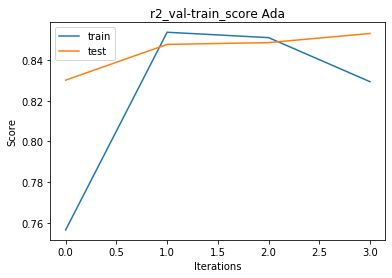

<Figure size 432x288 with 0 Axes>

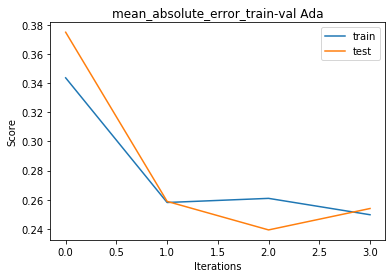

<Figure size 432x288 with 0 Axes>

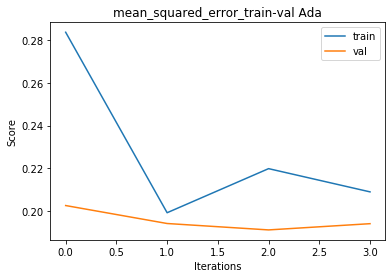

<Figure size 432x288 with 0 Axes>

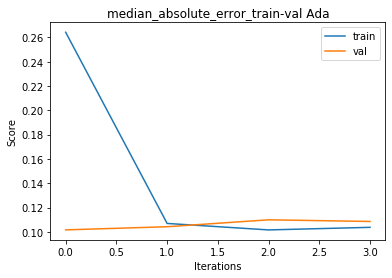

<Figure size 432x288 with 0 Axes>

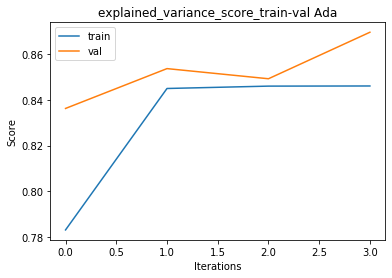

<Figure size 432x288 with 0 Axes>

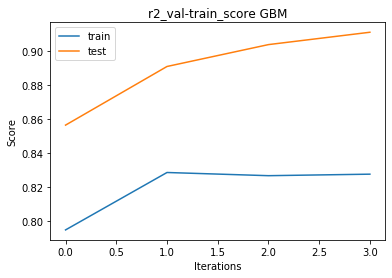

<Figure size 432x288 with 0 Axes>

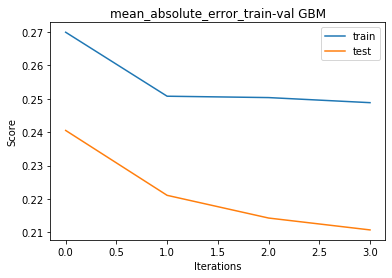

<Figure size 432x288 with 0 Axes>

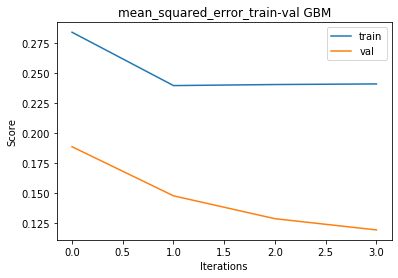

<Figure size 432x288 with 0 Axes>

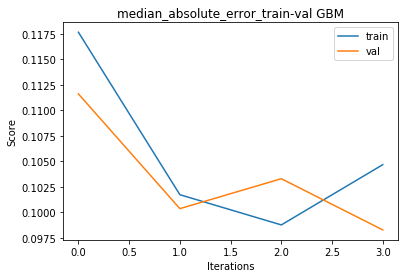

<Figure size 432x288 with 0 Axes>

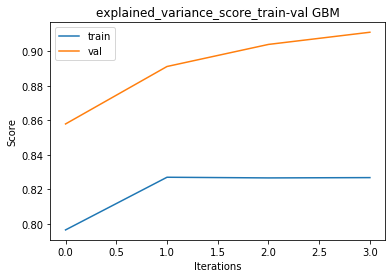

<Figure size 432x288 with 0 Axes>

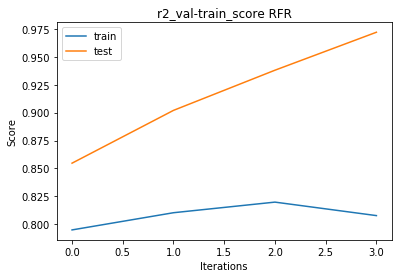

<Figure size 432x288 with 0 Axes>

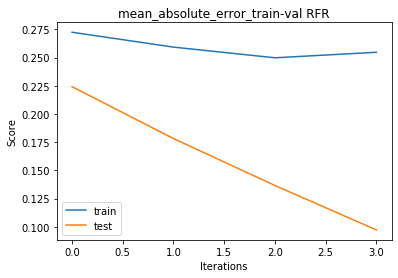

<Figure size 432x288 with 0 Axes>

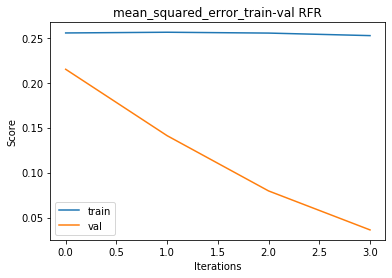

<Figure size 432x288 with 0 Axes>

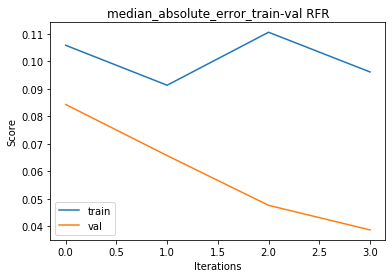

<Figure size 432x288 with 0 Axes>

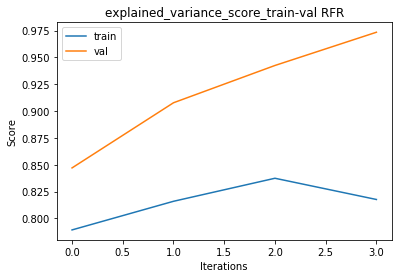

<Figure size 432x288 with 0 Axes>

In [176]:
%time result, models = train(models, X, Y, iterations=5)
result

In [129]:
y_test.head(10)

2424    0.100000
2779    1.457143
2011    1.181818
986     0.031250
3298    0.120000
3707    0.200000
2967    0.242424
1453    0.038462
3849    1.583333
2871    1.485714
Name: SaleRateNew, dtype: float64

In [189]:
#y_pred = models['Ada'].predict(X_test)
#y_pred[:10]

array([0.15873866, 1.07034832, 1.07034832, 0.05715962, 0.15873866,
       0.15873866, 0.16220228, 0.05715962, 1.07034832, 1.09736813])

#### Save and Load Machine Learning Models

In [177]:
from joblib import dump, load
dump(models['OLS'], 'OLS.joblib')

['OLS.joblib']

In [178]:
OLS = load('OLS.joblib') 

In [179]:
from joblib import dump, load
dump(models['Lasso'], 'Lasso.joblib')

['Lasso.joblib']

In [180]:
Lasso = load('Lasso.joblib') 

In [181]:
from joblib import dump, load
dump(models['Ridge'], 'Ridge.joblib')

['Ridge.joblib']

In [182]:
Ridge = load('Ridge.joblib') 

In [165]:
from joblib import dump, load
dump(models['Ada'], 'Ada.joblib') 

KeyError: 'Ada'

In [166]:
ada = load('Ada.joblib') 

In [167]:
from joblib import dump, load
dump(models['GBM'], 'GBM.joblib')

['GBM.joblib']

In [168]:
GBM = load('GBM.joblib') 

In [169]:
from joblib import dump, load
dump(models['RFR'], 'RFR.joblib')

['RFR.joblib']

In [170]:
RFR = load('RFR.joblib') 

### Tunning

In [414]:
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

ada_param = {
 'n_estimators': [50],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

gbm_param = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'max_depth':[1,3,5,7,9],
 'loss' : ['ls', 'lad', 'huber', 'quantile']
 }

RFR_param = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


models2 = {'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(X, Y).best_estimator_,
           'Ada': GridSearchCV(AdaBoostRegressor(), 
                               param_grid=ada_param).fit(X, Y).best_estimator_,
           'GBM': GridSearchCV(GradientBoostingRegressor(), 
                               param_grid=gbm_param).fit(X, Y).best_estimator_,
           'RFR': GridSearchCV(RandomForestRegressor(), 
                              param_grid=RFR_param).fit(X, Y).best_estimator_}


Running  Ridge
123456789
Running  Ada
123456789
Running  GBM
123456789
Running  RFR
123456789Wall time: 8min 46s


(       Ridge       Ada       GBM       RFR
 0   0.644343  0.785477  0.669844  0.208461
 1   0.692094  0.789300  0.745501  0.232447
 2   0.482897  0.381469  0.376182  0.684234
 3   0.460479  0.406733  0.361164  0.662365
 4   0.492197  0.296656  0.456764  1.086345
 5   0.412950  0.246251  0.338428  1.025038
 6   0.646950  0.812740  0.752089  0.204523
 7   0.692094  0.797002  0.832791  0.241692
 8   0.374533  0.448428  0.158024  0.589970
 9   0.378325  0.280238  0.169896  0.580409
 10  0.374533  0.448428  0.158024  0.589970
 11  0.378325  0.280238  0.169896  0.580409,
 {'Ridge': Ridge(alpha=200, copy_X=True, fit_intercept=True, max_iter=None,
        normalize=False, random_state=None, solver='auto', tol=0.001),
  'Ada': AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='exponential',
                    n_estimators=50, random_state=None),
  'GBM': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.3, loss='qu

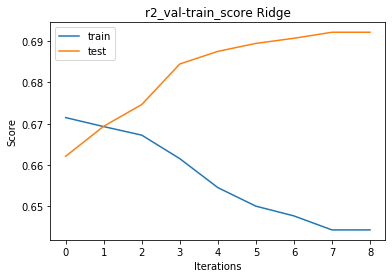

<Figure size 432x288 with 0 Axes>

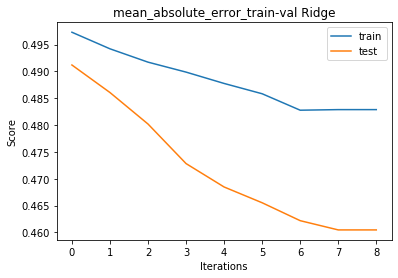

<Figure size 432x288 with 0 Axes>

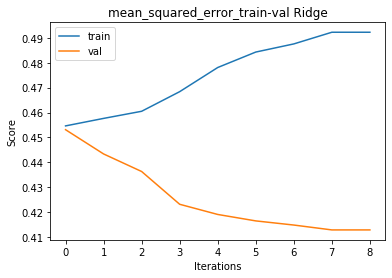

<Figure size 432x288 with 0 Axes>

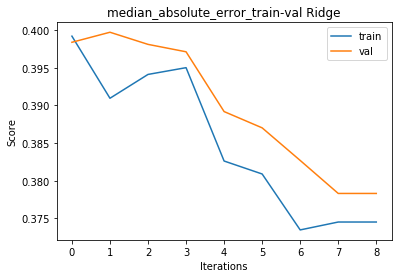

<Figure size 432x288 with 0 Axes>

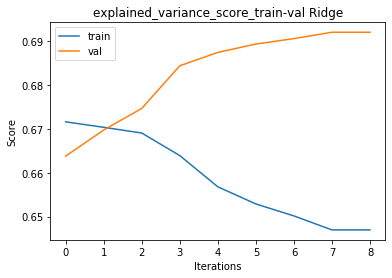

<Figure size 432x288 with 0 Axes>

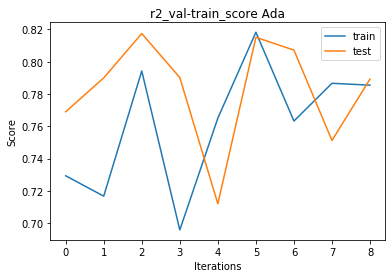

<Figure size 432x288 with 0 Axes>

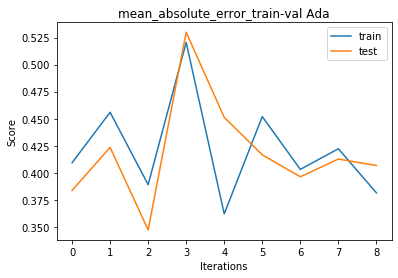

<Figure size 432x288 with 0 Axes>

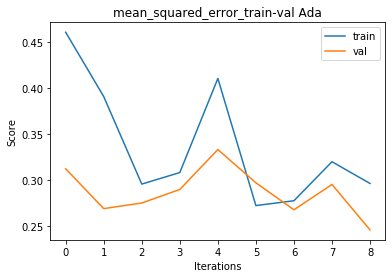

<Figure size 432x288 with 0 Axes>

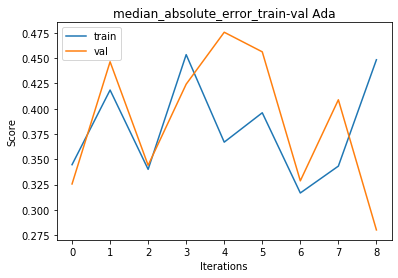

<Figure size 432x288 with 0 Axes>

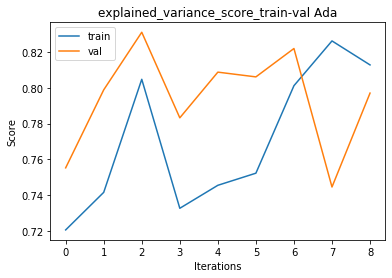

<Figure size 432x288 with 0 Axes>

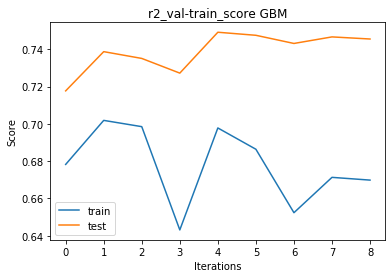

<Figure size 432x288 with 0 Axes>

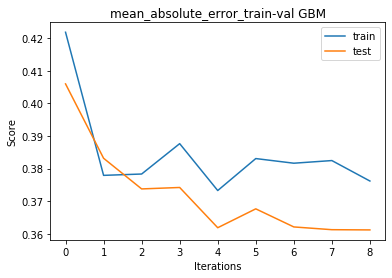

<Figure size 432x288 with 0 Axes>

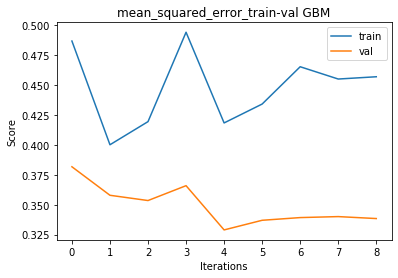

<Figure size 432x288 with 0 Axes>

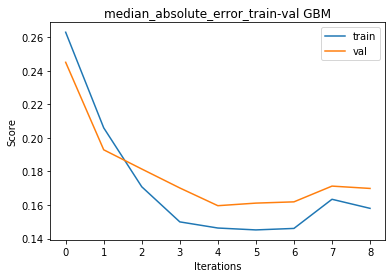

<Figure size 432x288 with 0 Axes>

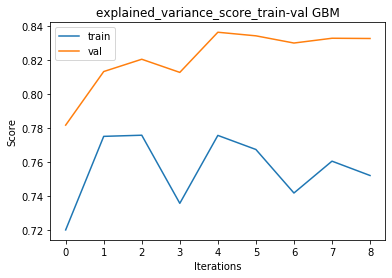

<Figure size 432x288 with 0 Axes>

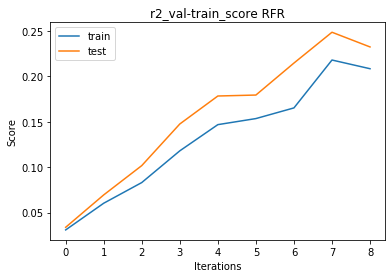

<Figure size 432x288 with 0 Axes>

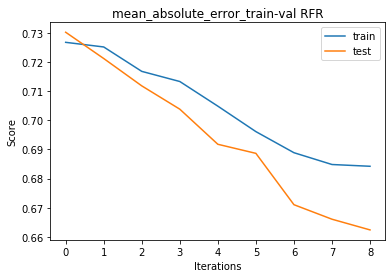

<Figure size 432x288 with 0 Axes>

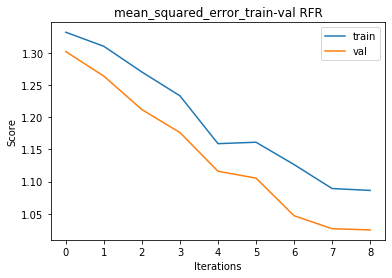

<Figure size 432x288 with 0 Axes>

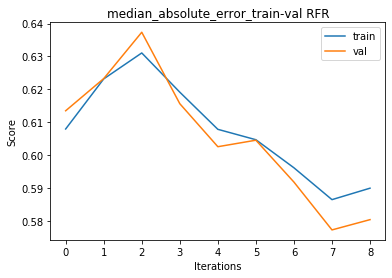

<Figure size 432x288 with 0 Axes>

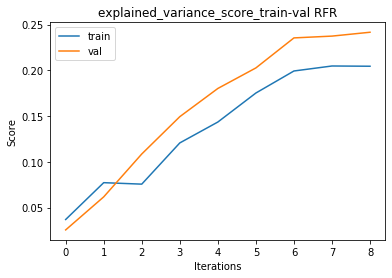

<Figure size 432x288 with 0 Axes>

In [415]:
%time test(models2, X, Y)

In [ ]:
X_test.Inventory

In [209]:
from joblib import dump, load
dump(models2['Ridge'], 'Ridge.joblib')

['Ridge.joblib']

In [210]:
Ridge = load('Ridge.joblib') 

In [211]:
from joblib import dump, load
dump(models2['Ada'], 'Ada.joblib') 

['Ada.joblib']

In [212]:
ada = load('Ada.joblib') 

In [213]:
from joblib import dump, load
dump(models2['GBM'], 'GBM.joblib')

['GBM.joblib']

In [214]:
GBM = load('GBM.joblib') 

In [215]:
from joblib import dump, load
dump(models2['RFR'], 'RFR.joblib')

['RFR.joblib']

In [216]:
RFR = load('RFR.joblib') 

In [217]:
models2['GBM']

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='quantile', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [218]:
GBM

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='quantile', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [156]:
#model prediction with testing
from matplotlib import pyplot as plt
%matplotlib inline

def test2(models, X, Y, iterations = 2):
    results = {}
    for i in models:
        print("\nRunning ", i)
        table = dict()
        for j in range(1, iterations):
            print(j, end='')
            table['r2_test'] = metrics.r2_score(y_test,
                                            models[i].predict(X_test))
            table['r2_train'] = metrics.r2_score(y_train, 
                                             models[i].predict(X_train))
            table['mae_train'] = metrics.mean_absolute_error(y_test,
                                            models[i].predict(X_test))
            table['mae_test'] = metrics.mean_absolute_error(y_train, 
                                             models[i].predict(X_train))
            table['mse_train'] = metrics.mean_squared_error(y_test,
                                            models[i].predict(X_test))
            table['mse_test'] = metrics.mean_squared_error(y_train, 
                                            models[i].predict(X_train))
            table['mabe_train'] = metrics.median_absolute_error(y_test,
                                            models[i].predict(X_test))
            table['mabe_test'] = metrics.median_absolute_error(y_train, 
                                            models[i].predict(X_train))
            table['mevs_train'] = metrics.explained_variance_score(y_test,
                                            models[i].predict(X_test))
            table['mevs_test'] = metrics.explained_variance_score(y_train, 
                                            models[i].predict(X_train))
        
        results[i] = table
    return pd.DataFrame(results), models

In [157]:
from joblib import dump, load
models = {'OLS': load('OLS.joblib'),
           'Ridge': load('Ridge.joblib'),
           'ada': load('ada.joblib'),
           'GBM': load('GBM.joblib'),
           'RFR': load('RFR.joblib')}


In [98]:
models

{'OLS': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'Ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 'ada': AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                   n_estimators=50, random_state=None),
 'GBM': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.

In [99]:
#metrics.r2_score(y_test,models2['Ada'].predict(X_test))

In [100]:
%time result, models = test2(models, X, Y)
result


Running  OLS
1

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

,OLS,Ridge,ada,GBM,RFR
r2_test,0.572754,0.577496,0.799369,0.851207,0.839479
r2_train,0.727477,0.725177,0.850948,0.911018,0.976149
mae_train,0.423511,0.420216,0.223288,0.200266,0.202918
mae_test,0.426090,0.429148,0.257115,0.210763,0.097716
mse_train,0.345859,0.342019,0.162412,0.120449,0.129943
mse_test,0.365496,0.368581,0.199902,0.119339,0.031988
mabe_train,0.322676,0.324597,0.088339,0.076322,0.083474
mabe_test,0.324238,0.324720,0.109285,0.098270,0.038410
mevs_train,0.573639,0.578245,0.801296,0.851253,0.839714
mevs_test,0.727477,0.725177,0.852540,0.911018,0.976149


In [94]:
for i in result:
    print(dict(result[i]))

{'OLS': 0.5727538371572456, 'Ridge': 0.5774963397270205, 'ada': 0.7993689782873731, 'GBM': 0.8512070636063174, 'RFR': 0.8394789040075306}
{'OLS': 0.727477054314466, 'Ridge': 0.725177248099143, 'ada': 0.8509484731469266, 'GBM': 0.9110179066192918, 'RFR': 0.9761492023492685}
{'OLS': 0.4235105154678971, 'Ridge': 0.420216022888532, 'ada': 0.2232875982189878, 'GBM': 0.20026613166278062, 'RFR': 0.20291802712923626}
{'OLS': 0.426090312886432, 'Ridge': 0.4291477211737384, 'ada': 0.2571154974798963, 'GBM': 0.21076287521708295, 'RFR': 0.09771636539541186}
{'OLS': 0.3458585356265309, 'Ridge': 0.34201944908430454, 'ada': 0.162412111343695, 'GBM': 0.12044884557952287, 'RFR': 0.12994286672518165}
{'OLS': 0.36549614503833905, 'Ridge': 0.36858054699180137, 'ada': 0.19990154715169953, 'GBM': 0.11933898639719831, 'RFR': 0.03198767199401574}
{'OLS': 0.3226760045292003, 'Ridge': 0.3245970808373305, 'ada': 0.08833900586199135, 'GBM': 0.076321503107561, 'RFR': 0.08347365969999992}
{'OLS': 0.3242383318938495

OLS


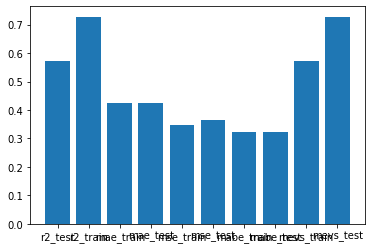

Ridge


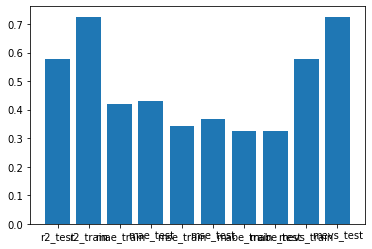

ada


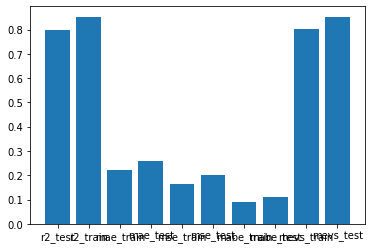

GBM


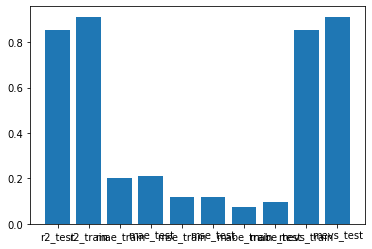

RFR


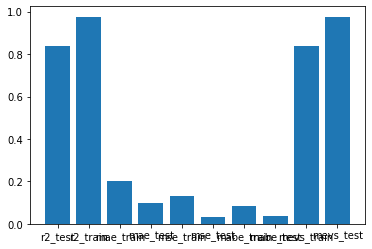

In [95]:
import matplotlib.pyplot as plt
result = result.transpose()
for key in result:
    print(key)
    plt.bar(range(len(dict(result[key]))), list(dict(result[key]).values()), align='center')
    plt.xticks(range(len(dict(result[key]))), list(dict(result[key]).keys()))
    plt.show()

In [24]:
models

{'OLS': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'Lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 'Ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 'ada': AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                   n_estimators=50, random_state=None),
 'GBM': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0

In [125]:
X_test

,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),0,1,2,3,...,448,449,450,451,452,453,454,455,456,457
2424,16.13,12.0975,4,2.5,1.5325,0.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,6.38,4.7850,51,0.0,1.5950,0.23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,3.59,2.6925,52,0.0,0.8975,0.22,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
986,173.23,129.9225,2,2.5,40.8075,3.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3298,398.72,299.0400,3,2.5,97.1800,0.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,736.97,552.7275,30,2.5,181.7425,4.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1823,54.84,41.1300,4,2.5,11.2100,3.85,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,2930.48,2197.8600,1,10.0,722.6200,143.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2458,27.67,20.7525,51,0.0,6.9175,0.03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Number of days prediction (i.e Blowout period)

In [63]:
y_pred = RFR.predict(X_test)
print(y_pred[:10])
print(y_test.head(10))

[0.0875     0.55247685 1.09928468 0.03480963 0.08158485 0.10714023
 0.26502525 0.17892196 1.06342814 1.11097352]
2424    0.100000
2779    1.457143
2011    1.181818
986     0.031250
3298    0.120000
3707    0.200000
2967    0.242424
1453    0.038462
3849    1.583333
2871    1.485714
Name: SaleRateNew, dtype: float64


In [70]:
y_test

2424    0.100000
2779    1.457143
2011    1.181818
986     0.031250
3298    0.120000
          ...   
416     0.348837
1823    0.086957
1167    0.016393
2458    1.275000
2425    0.150000
Name: SaleRateNew, Length: 420, dtype: float64

In [71]:
#blowout
#np.set_printoptions(formatter={'float_kind':float_formatter})
X_test['y_pred'] = y_pred
X_test['blowout_pred'] = pd.DataFrame({"Days" : X_test.Inventory / X_test['y_pred']})
X_test['blowout_test'] = pd.DataFrame({"Days" : X_test.Inventory / y_test})
X_test.head(10)

,Price(USD),Cost price,Inventory,Shipping,Profit,weight(lb),0,1,2,3,...,451,452,453,454,455,456,457,y_pred,blowout_pred,blowout_test
2424,16.13,12.0975,4,2.5,1.5325,0.26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087500,45.714286,40.000000
2779,6.38,4.7850,51,0.0,1.5950,0.23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552477,92.311560,35.000000
2011,3.59,2.6925,52,0.0,0.8975,0.22,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.099285,47.303488,44.000000
986,173.23,129.9225,2,2.5,40.8075,3.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034810,57.455367,64.000000
3298,398.72,299.0400,3,2.5,97.1800,0.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081585,36.771532,25.000000
3707,196.80,147.6000,3,2.5,46.7000,4.40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107140,28.000687,15.000000
2967,199.87,149.9025,8,10.0,39.9675,37.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265025,30.185803,33.000000
1453,1023.97,767.9775,2,10.0,245.9925,82.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178922,11.178058,52.000001
3849,30.65,22.9875,20,2.5,5.1625,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.063428,18.807101,12.631579
2871,110.70,83.0250,52,2.5,25.1750,5.56,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.110974,46.805796,35.000000


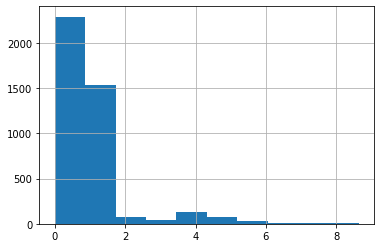

In [247]:
pd.plotting.hist_series(Y)